# Merge Conflict Prediction in Software Projects
This notebook implements a machine learning solution to predict merge conflicts in software projects using scikit-learn. Following the end-to-end machine learning project methodology, we'll build classifiers that can identify potential conflicts before they occur, potentially saving developer time and reducing integration challenges.


# Setup

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Setting Seaborn style for better visualizations
sns.set(style="whitegrid")

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "merge_conflict_classifier"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Loading and Visual Exploration

We begin by loading the MergeConflictsDataset.csv and exploring its basic properties. The dataset contains information about:
- Pull request status
- Number of added/deleted lines
- Number of developers on each branch
- Duration of parallel development
- Number of changed files
- Commit metrics (count, density)
- Commit message characteristics

We'll analyze these features to identify patterns that predict merge conflicts.


In [69]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv('MergeConflictsDataset.csv', sep=';')

Loading dataset...


In [70]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

Dataset shape: (26973, 37)

Sample data:
                                     commit  \
0  efc0bcd1d6199448c323549fdc45310750b48c85   
1  287b9b838b6b6b212ef538aa537aef76110ee111   
2  e7478680c0db825239ea9628967728c8577bb5c2   
3  0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff   
4  419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f   

                                    parent1  \
0  fb9f2a65cabba5a924b89a45793914066471b2ab   
1  72fd7d81c9c7e28af8740f5a1b210a803290383d   
2  36977963caa2896ad9a4a92b2bdcd85189beccb1   
3  419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f   
4  7899f565d3461ed287e61662c8d399aafcac9e42   

                                    parent2  \
0  5ee7c7c750e9ecffaea12f97d5b05b2445e7c007   
1  fb9f2a65cabba5a924b89a45793914066471b2ab   
2  bc230857adc3a9763bc7d89793d826463c857c00   
3  877c43f8242b88447d0234400c6e9b5c7586b558   
4  5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6   

                                   ancestor  is pr  added lines  \
0  fb9f2a65cabba5a924b89a45793914066471b2ab

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

In [87]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")


Missing values per column:
ancestor    1
dtype: int64


In [73]:
# Check target variable distribution
print("\nTarget variable distribution:")
conflict_counts = df['conflict'].value_counts()
conflict_percentage = df['conflict'].mean() * 100
print(conflict_counts)
print(f"Percentage of conflicts: {conflict_percentage:.2f}%")


Target variable distribution:
conflict
0    25505
1     1468
Name: count, dtype: int64
Percentage of conflicts: 5.44%


Saving figure class_distribution.png


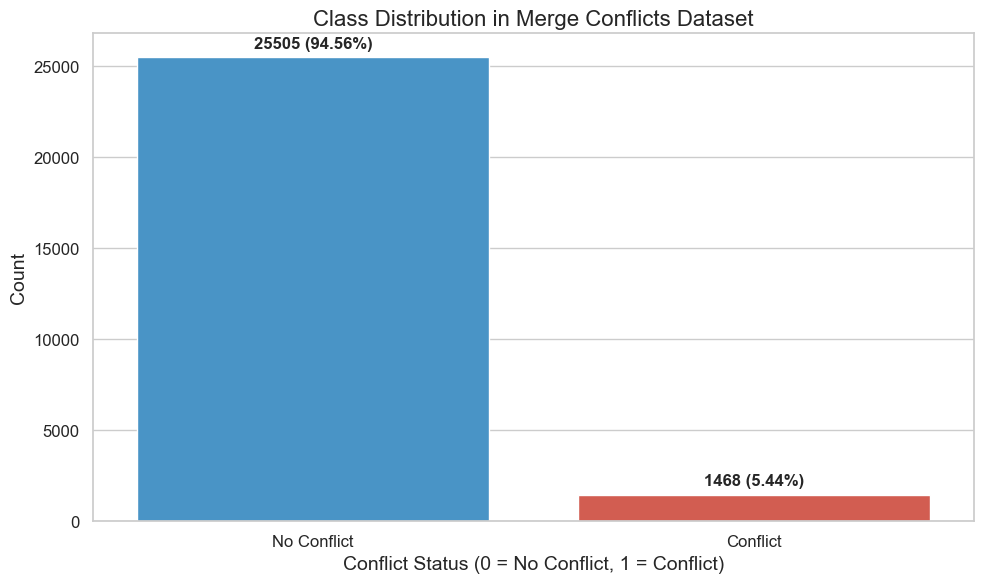

In [74]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='conflict', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Class Distribution in Merge Conflicts Dataset', fontsize=16)
plt.xlabel('Conflict Status (0 = No Conflict, 1 = Conflict)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['No Conflict', 'Conflict'])

# Annotate the bars with counts and percentages
for i, count in enumerate(conflict_counts):
    plt.text(i, count + 500, f'{count} ({count/len(df)*100:.2f}%)', 
             ha='center', fontsize=12, fontweight='bold')
save_fig('class_distribution')
plt.show()

In [75]:
# Identify non-feature columns (commit hashes and identifiers)
non_feature_cols = ['commit', 'parent1', 'parent2', 'ancestor']
feature_cols = [col for col in df.columns if col not in non_feature_cols and col != 'conflict']

In [76]:
# Prepare features and target
X = df[feature_cols]
y = df['conflict']

In [92]:
print(f"\nNumber of features: {len(feature_cols)}")
print("\nFeature columns:")
for i, col in enumerate(feature_cols):
    print(f"{i+1}. {col}")


Number of features: 32

Feature columns:
1. is pr
2. added lines
3. deleted lines
4. devs parent1
5. devs parent2
6. time
7. nr files
8. added files
9. deleted files
10. renamed files
11. copied files
12. modified files
13. nr commits1
14. nr commits2
15. density1
16. density2
17. fix
18. bug
19. feature
20. improve
21. document
22. refactor
23. update
24. add
25. remove
26. use
27. delete
28. change
29. messages_min
30. messages_max
31. messages_mean
32. messages_median


**Initial observations:**
- The dataset contains 26,973 records with 37 columns
- There is significant class imbalance with only 5.44% of cases representing conflicts
- No missing values are detected, which simplifies the preprocessing

The severe class imbalance (94.56% non-conflicts vs. 5.44% conflicts) will be a key challenge for the modeling approach. This means accuracy would be a misleading metric—a model always predicting "no conflict" would achieve 94.56% accuracy but provide no value.

## Data Analysis 

### Statistical Summary

The descriptive statistics reveal wide ranges for many features:
- Some merges involve hundreds of developers
- Line additions/deletions can exceed 1 million
- Time duration ranges from 0 to over 21,000 hours
- The number of files changed ranges from 0 to over 1,100

These extreme ranges suggest we'll need scaling to handle these variations. Additionally, some very large values may represent outliers, but they could also represent legitimate complex merges that are more likely to cause conflicts.

In [108]:
# Statistical summary of numerical features
print("\nStatistical summary of numerical features:")
df.describe()


Statistical summary of numerical features:


,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
count,26973.000000,2.697300e+04,2.697300e+04,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,...,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000
mean,0.777741,4.255746e+02,2.504278e+02,4.656175,1.911801,240.714159,0.752048,2.431061,1.396545,0.970229,...,4.316205,0.955437,1.338857,0.096281,1.007860,51.391280,104.662551,69.455646,68.021095,0.054425
std,0.415772,8.887706e+03,1.027916e+04,12.230444,6.534316,908.382038,10.620490,67.840678,90.614277,64.245155,...,12.924317,3.203307,4.269666,0.541916,6.033535,34.560112,89.471017,40.057823,39.385369,0.226858
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000e+00,1.000000e+00,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,47.000000,41.000000,40.000000,0.000000
50%,1.000000,1.100000e+01,2.000000e+00,1.000000,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,46.000000,88.000000,66.391304,65.000000,0.000000
75%,1.000000,7.500000e+01,1.500000e+01,3.000000,1.000000,139.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,67.000000,131.000000,91.714286,90.000000,0.000000
max,1.000000,1.140945e+06,1.140456e+06,158.000000,182.000000,21513.000000,1152.000000,10404.000000,10396.000000,10398.000000,...,176.000000,48.000000,78.000000,16.000000,312.000000,1326.000000,1326.000000,1326.000000,1326.000000,1.000000


### Feature Distributions by Conflict Status

Saving figure feature_boxplots


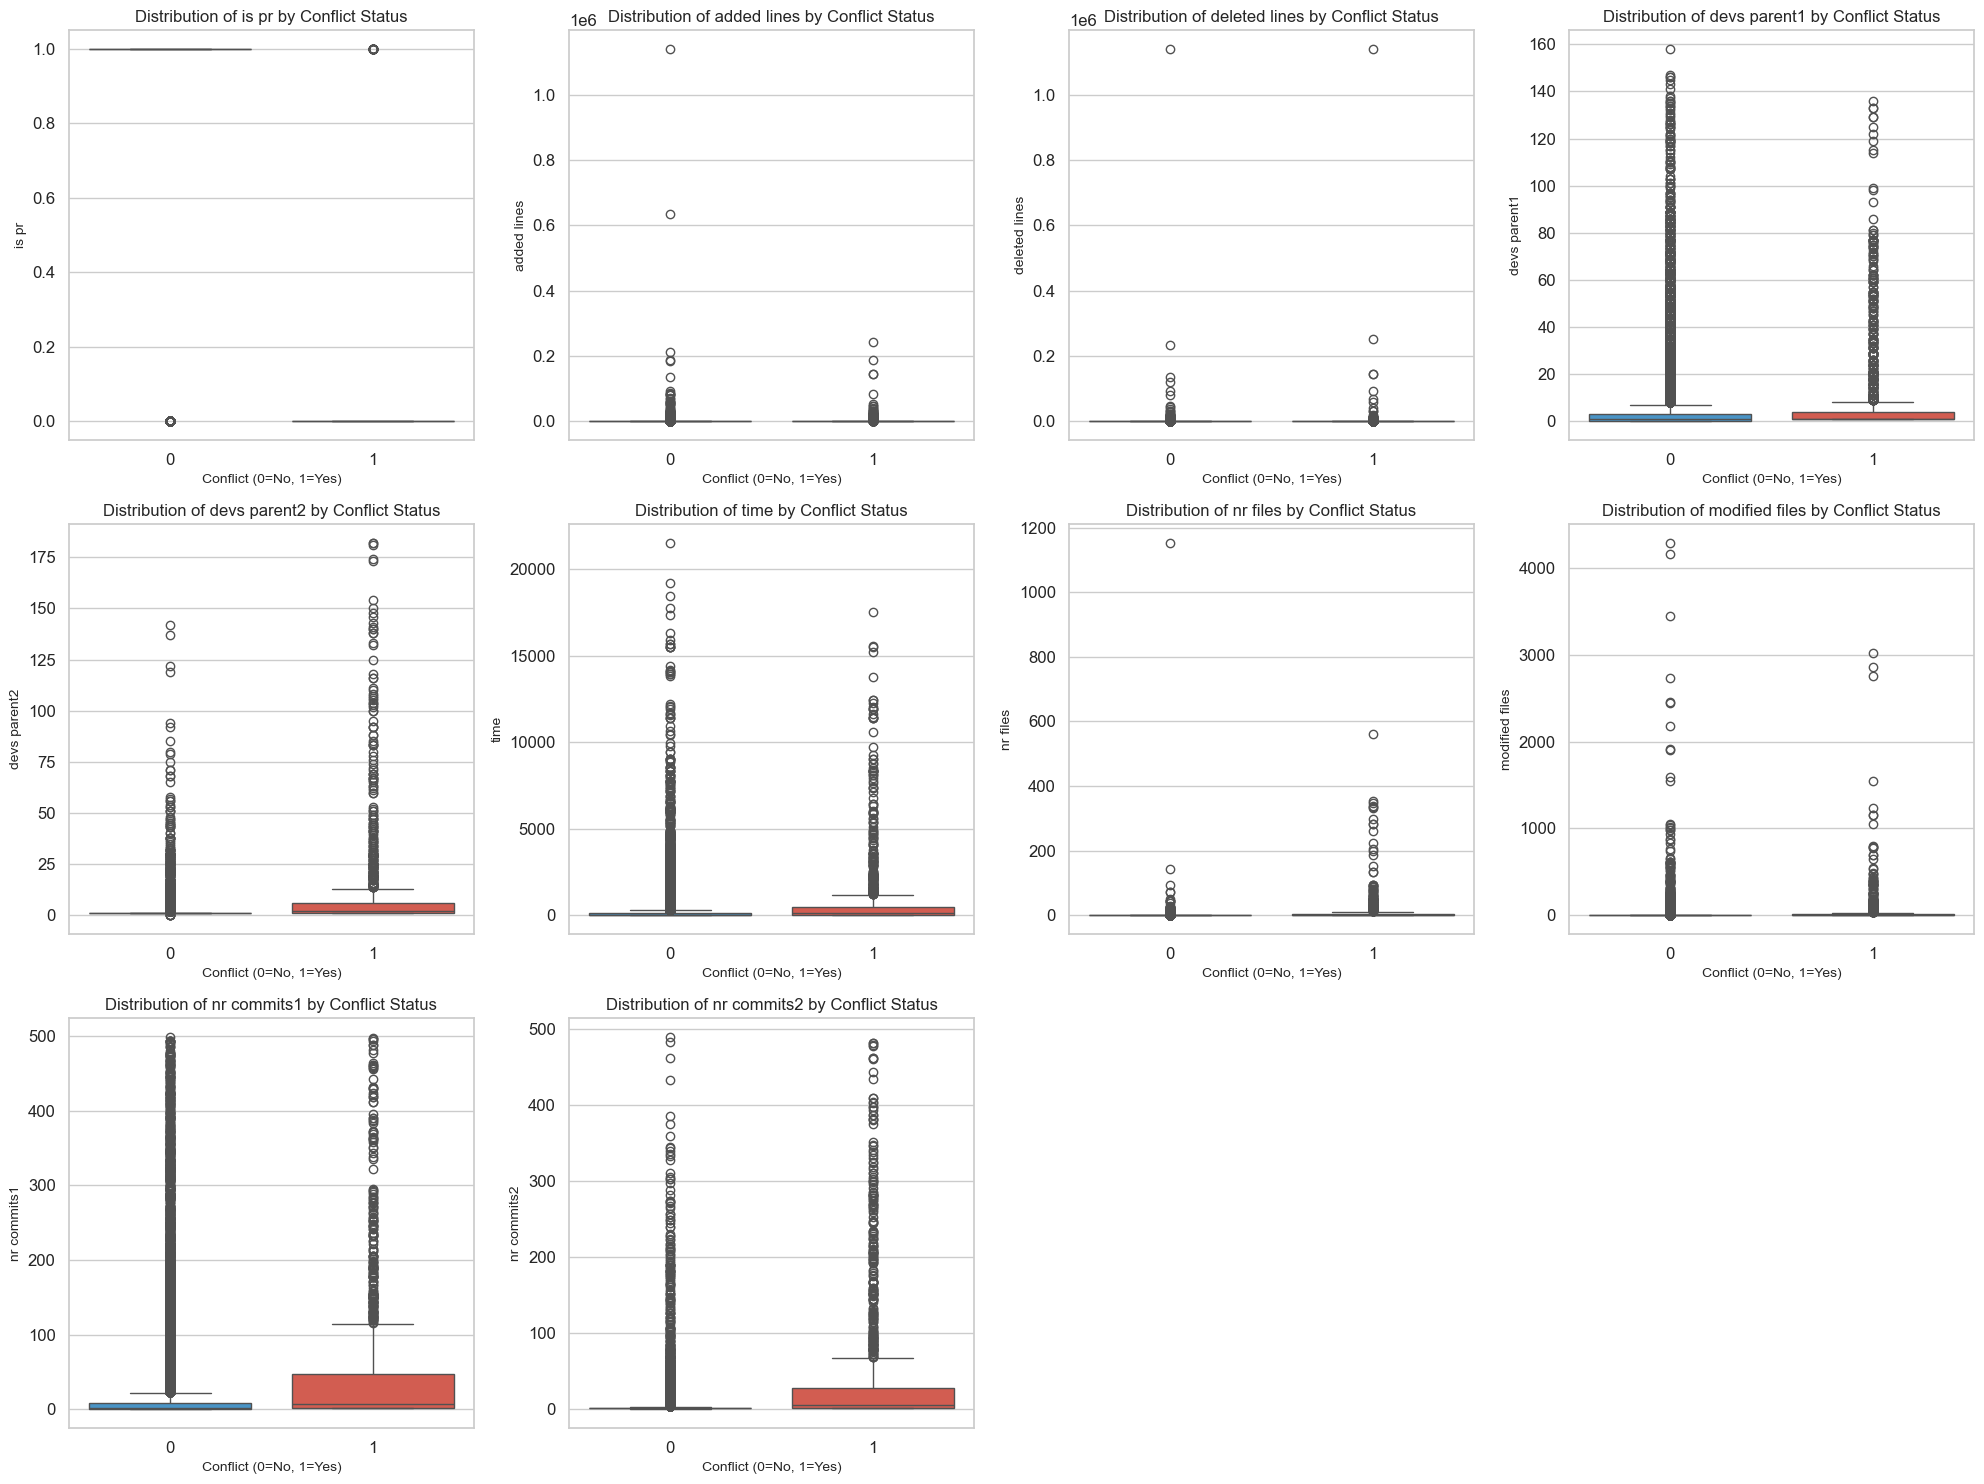

In [116]:
# Check distributions of key features by conflict status
plt.figure(figsize=(20, 15))
features_to_plot = ['is pr', 'added lines', 'deleted lines', 'devs parent1', 
                   'devs parent2', 'time', 'nr files', 'modified files', 
                   'nr commits1', 'nr commits2']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='conflict', y=feature, data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Conflict Status', fontsize=12)
    plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    # # Add mean values with percentages on the plot
    # for j, conflict in enumerate([0, 1]):
    #     mean_val = df[df['conflict'] == conflict][feature].mean()
    #     plt.text(j, mean_val, f'Mean: {mean_val:.1f}', 
    #              ha='center', va='bottom', fontsize=9, fontweight='bold')
    
plt.tight_layout()
save_fig('feature_boxplots')
plt.show()

In [93]:
# Check distribution statistics for key features
print("\nDistribution statistics for key features by conflict status:")
for feature in features_to_plot:
    conflict_stats = df[df['conflict'] == 1][feature].describe()[['mean', '50%', 'max']]
    no_conflict_stats = df[df['conflict'] == 0][feature].describe()[['mean', '50%', 'max']]
    
    print(f"\n{feature}:")
    print(f"  Conflict cases - Mean: {conflict_stats['mean']:.2f}, Median: {conflict_stats['50%']:.2f}, Max: {conflict_stats['max']:.2f}")
    print(f"  No conflict cases - Mean: {no_conflict_stats['mean']:.2f}, Median: {no_conflict_stats['50%']:.2f}, Max: {no_conflict_stats['max']:.2f}")
    print(f"  Ratio (conflict/no-conflict) - Mean: {conflict_stats['mean']/no_conflict_stats['mean']:.2f}, Median: {conflict_stats['50%']/no_conflict_stats['50%']:.2f}")


Distribution statistics for key features by conflict status:

is pr:
  Conflict cases - Mean: 0.02, Median: 0.00, Max: 1.00
  No conflict cases - Mean: 0.82, Median: 1.00, Max: 1.00
  Ratio (conflict/no-conflict) - Mean: 0.02, Median: 0.00

added lines:
  Conflict cases - Mean: 1913.09, Median: 106.50, Max: 243899.00
  No conflict cases - Mean: 339.96, Median: 10.00, Max: 1140945.00
  Ratio (conflict/no-conflict) - Mean: 5.63, Median: 10.65

deleted lines:
  Conflict cases - Mean: 1827.88, Median: 20.00, Max: 1140456.00
  No conflict cases - Mean: 159.63, Median: 2.00, Max: 1139738.00
  Ratio (conflict/no-conflict) - Mean: 11.45, Median: 10.00

devs parent1:
  Conflict cases - Mean: 8.42, Median: 1.00, Max: 136.00
  No conflict cases - Mean: 4.44, Median: 1.00, Max: 158.00
  Ratio (conflict/no-conflict) - Mean: 1.90, Median: 1.00

devs parent2:
  Conflict cases - Mean: 9.39, Median: 2.00, Max: 182.00
  No conflict cases - Mean: 1.48, Median: 1.00, Max: 142.00
  Ratio (conflict/no-conf

In [91]:
# Check for extreme values in key features
print("\nExtreme values in key features:")
for feature in features_to_plot:
    percentiles = [0, 50, 90, 95, 99, 100]
    p_values = np.percentile(X[feature], percentiles)
    print(f"{feature} percentiles {percentiles}: {p_values}")


Extreme values in key features:
is pr percentiles [0, 50, 90, 95, 99, 100]: [0. 1. 1. 1. 1. 1.]
added lines percentiles [0, 50, 90, 95, 99, 100]: [0.000000e+00 1.100000e+01 3.160000e+02 7.760000e+02 5.377280e+03
 1.140945e+06]
deleted lines percentiles [0, 50, 90, 95, 99, 100]: [0.000000e+00 2.000000e+00 9.200000e+01 2.630000e+02 2.247640e+03
 1.140456e+06]
devs parent1 percentiles [0, 50, 90, 95, 99, 100]: [  0.   1.  10.  23.  68. 158.]
devs parent2 percentiles [0, 50, 90, 95, 99, 100]: [  0.     1.     2.     3.    21.28 182.  ]
time percentiles [0, 50, 90, 95, 99, 100]: [    0.     36.    452.    909.4  3982.  21513. ]
nr files percentiles [0, 50, 90, 95, 99, 100]: [0.000e+00 0.000e+00 1.000e+00 2.000e+00 9.000e+00 1.152e+03]
modified files percentiles [0, 50, 90, 95, 99, 100]: [0.000e+00 1.000e+00 8.000e+00 1.700e+01 1.100e+02 4.289e+03]
nr commits1 percentiles [0, 50, 90, 95, 99, 100]: [  0.    2.   44.  102.4 333.  499. ]
nr commits2 percentiles [0, 50, 90, 95, 99, 100]: [  0. 

**Key observations:**
- **Number of files (`nr files`)**: Dramatically higher in conflict cases 
- **Modified files**: Considerably more in conflict cases 
- **Developer count**: More developers are involved in conflict cases
- **Commit counts**: Conflict cases show higher commit activity
- **Time**: Longer parallel development correlates with conflicts

These differences provide strong signals for our predictive models. Merges with more files changed, more developers involved, and longer development times are much more likely to result in conflicts.

The extreme values (outliers) appear to be meaningful rather than errors, as they often correspond to conflict cases. We'll preserve these values rather than removing them.

### Correlation Analysis

In [94]:
# Correlation with target
correlation_with_target = X.corrwith(y).sort_values(ascending=False)
print("\nTop 10 features by correlation with target (conflict):")
print(correlation_with_target.head(10))

print("\nBottom 5 features by correlation with target (conflict):")
print(correlation_with_target.tail(5))


Top 10 features by correlation with target (conflict):
nr commits2     0.303397
devs parent2    0.274583
add             0.235729
density2        0.219509
remove          0.202772
nr files        0.172194
fix             0.164832
update          0.158182
messages_max    0.153547
refactor        0.144355
dtype: float64

Bottom 5 features by correlation with target (conflict):
added files        0.019285
messages_median    0.018941
messages_min      -0.082620
is pr             -0.436992
copied files            NaN
dtype: float64


Saving figure feature_target_correlation


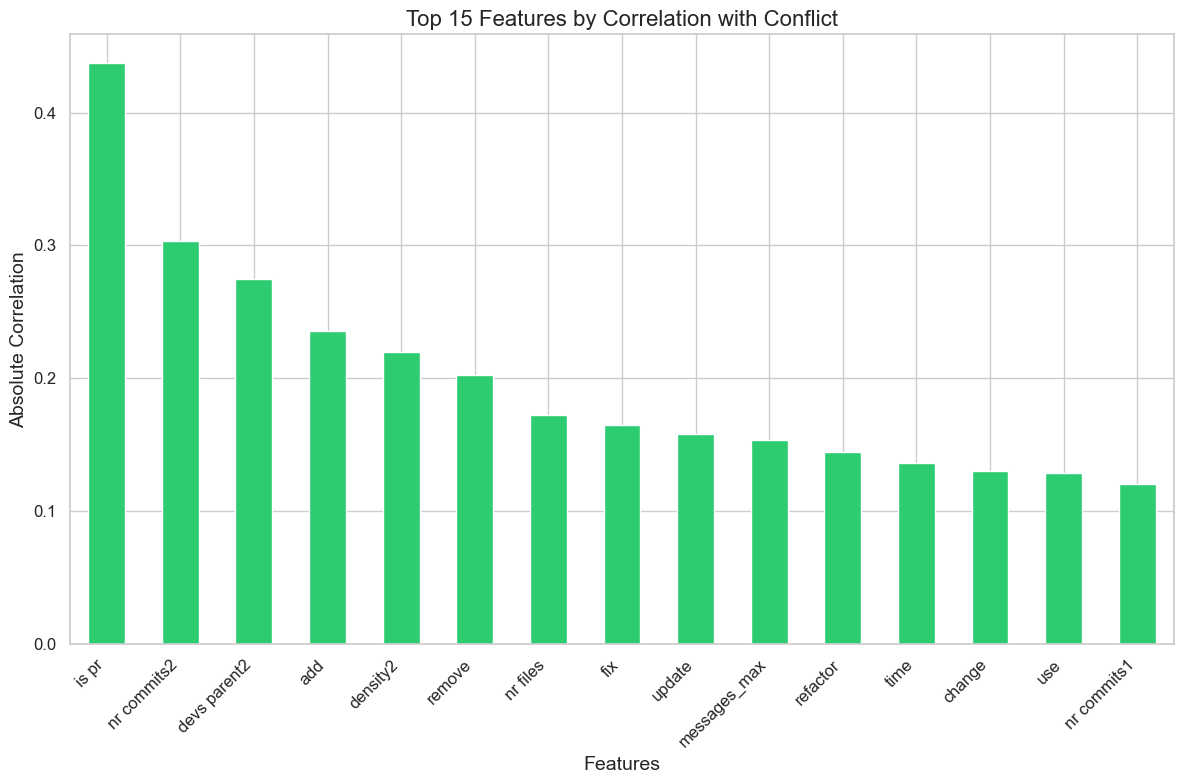

In [121]:
# Visualize top correlated features with target
plt.figure(figsize=(12, 8))
correlation_with_target.abs().sort_values(ascending=False).head(15).plot(kind='bar', color='#2ecc71')
plt.title('Top 15 Features by Correlation with Conflict', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Absolute Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('feature_target_correlation')
plt.show()


Saving figure correlation_heatmap


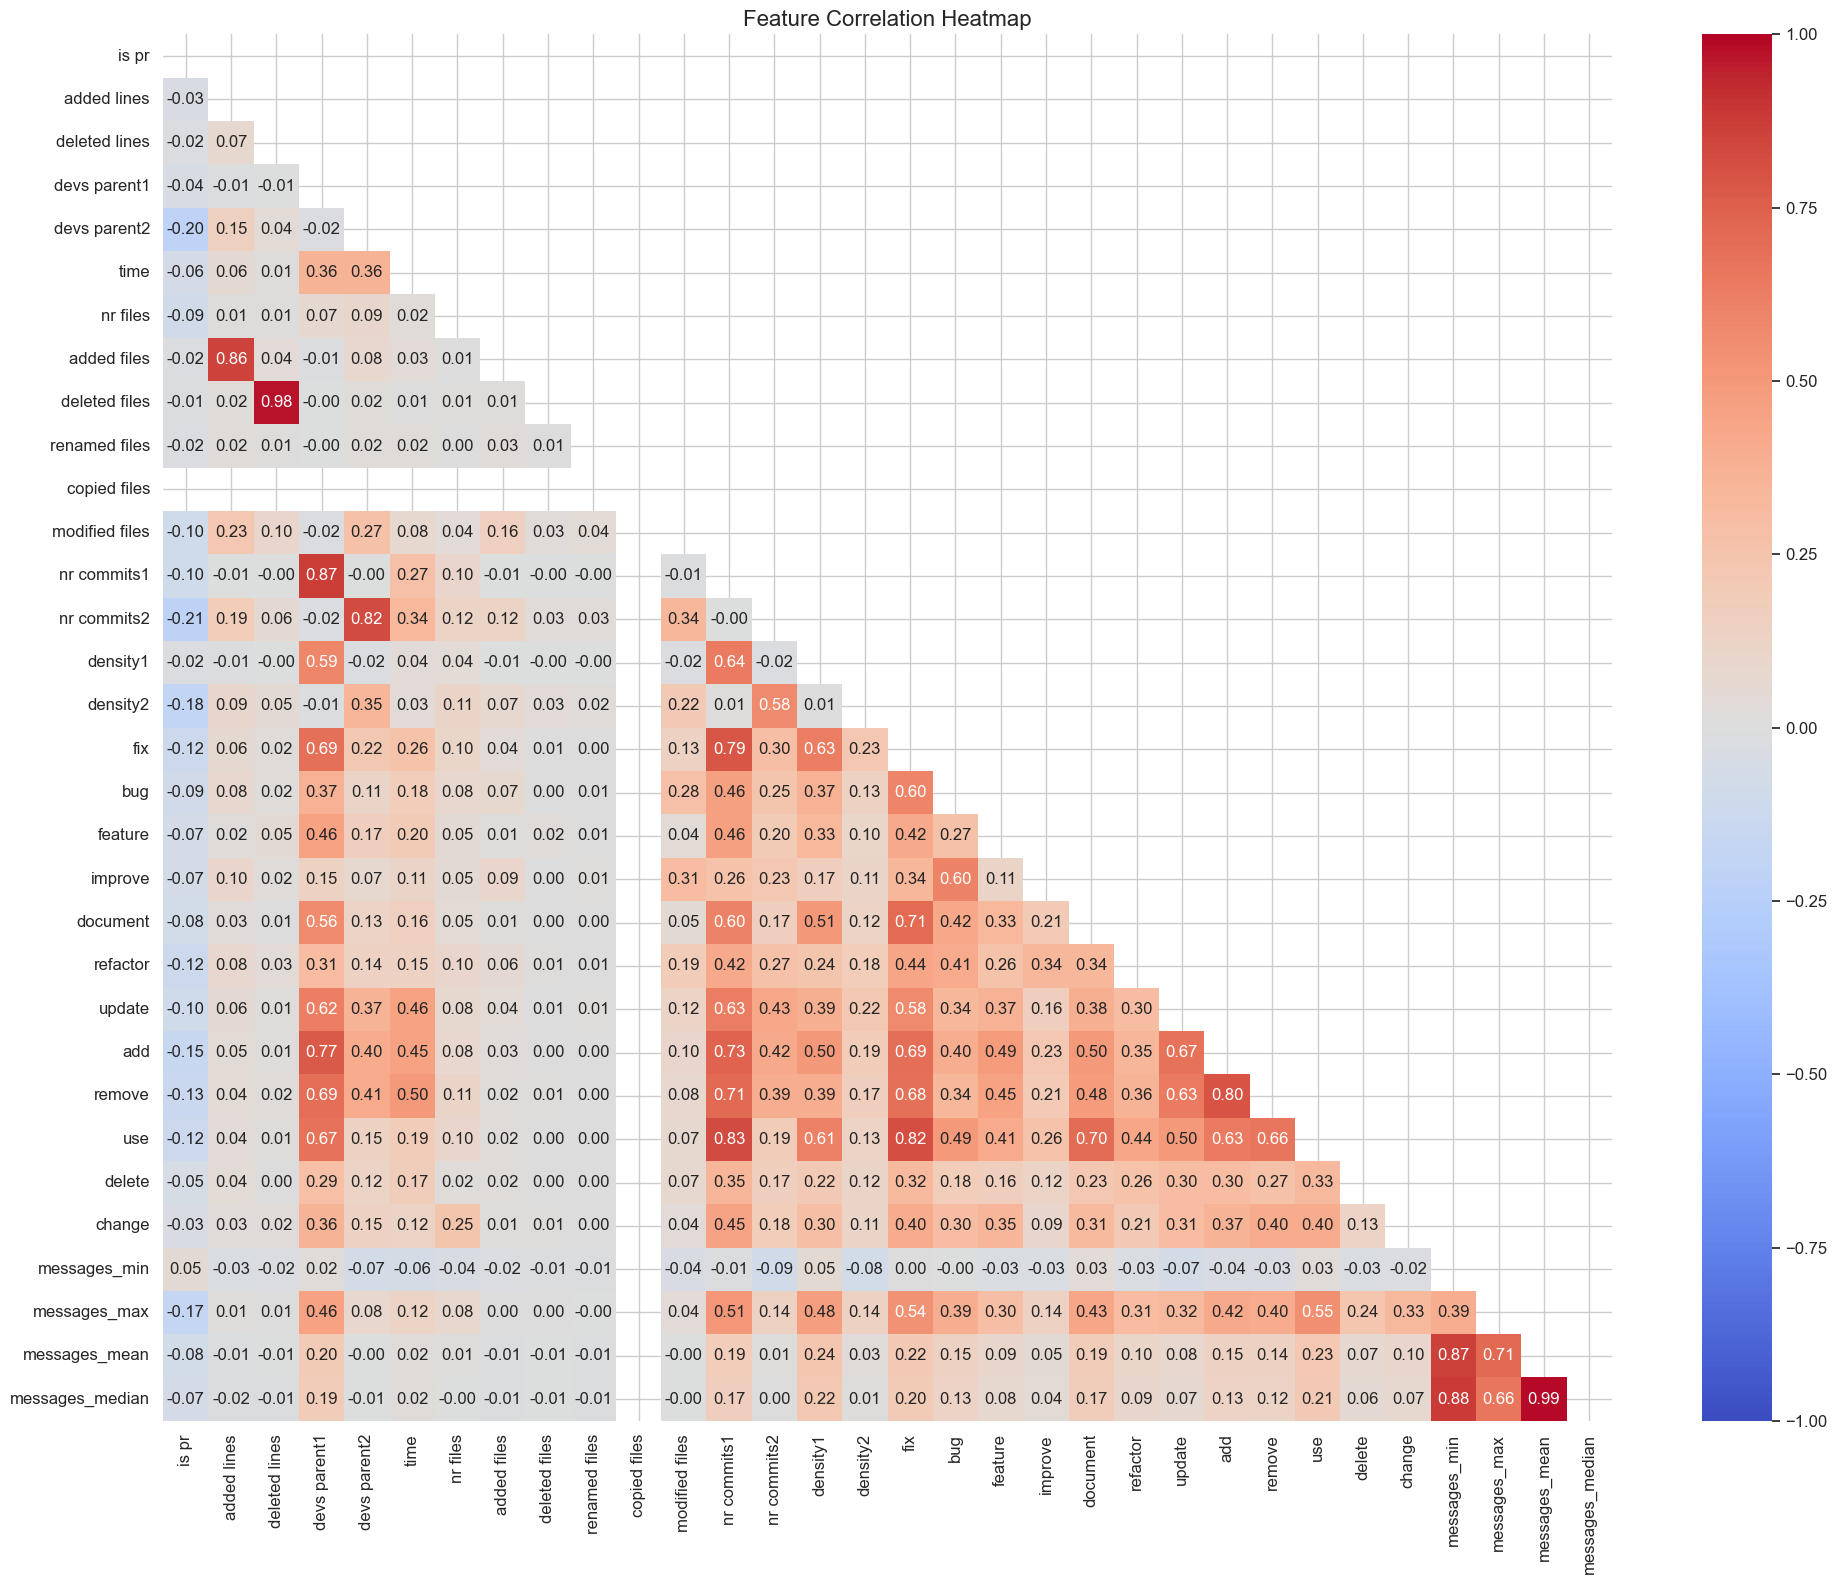

In [ ]:
# Correlation heatmap between features
plt.figure(figsize=(20, 16))
# # Select key features for a more readable heatmap
# key_features = ['is pr', 'nr files', 'modified files', 'deleted files', 
#                 'renamed files', 'devs parent1', 'devs parent2', 
#                 'nr commits1', 'nr commits2', 'time', 'conflict']
#correlation = df[key_features].corr()
correlation = X.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
save_fig('correlation_heatmap')
plt.show()

### PR Status Analysis


Saving figure pr_vs_conflict


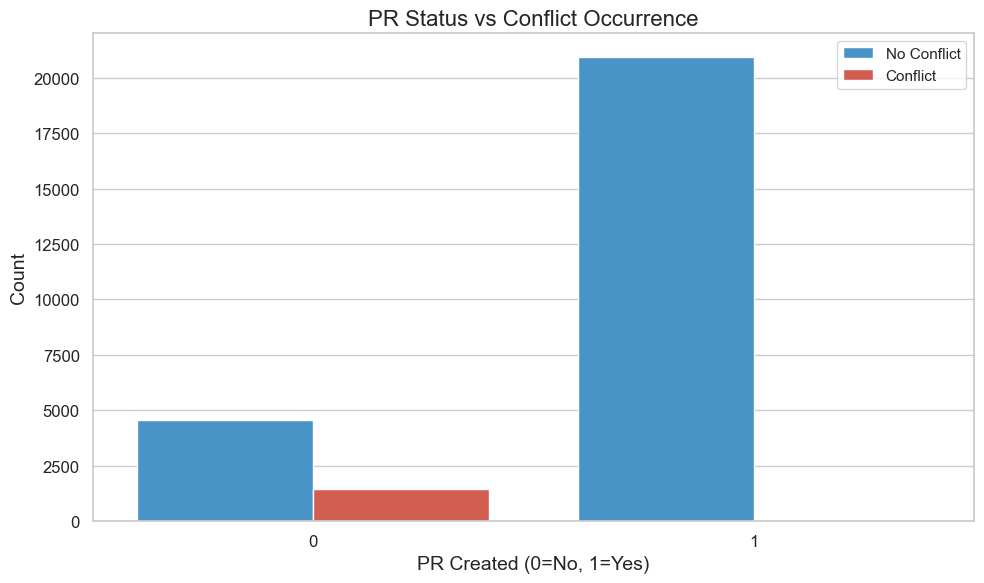

In [127]:
# Check relationship between PR status and conflicts
plt.figure(figsize=(10, 6))
sns.countplot(x='is pr', hue='conflict', data=df, palette=['#3498db', '#e74c3c'])
plt.title('PR Status vs Conflict Occurrence', fontsize=16)
plt.xlabel('PR Created (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.tight_layout()
save_fig('pr_vs_conflict')
plt.show()

In [128]:
# Calculate PR impact statistics
pr_conflict_rate = df[df['is pr'] == 1]['conflict'].mean() * 100
no_pr_conflict_rate = df[df['is pr'] == 0]['conflict'].mean() * 100
print(f"\nConflict rate when PR is used: {pr_conflict_rate:.2f}%")
print(f"Conflict rate when PR is NOT used: {no_pr_conflict_rate:.2f}%")
print(f"PR reduces conflict probability by {(no_pr_conflict_rate - pr_conflict_rate)/no_pr_conflict_rate*100:.2f}%")


Conflict rate when PR is used: 0.14%
Conflict rate when PR is NOT used: 23.99%
PR reduces conflict probability by 99.40%


**PR status analysis:**
- Using Pull Requests (`is pr`=1) dramatically reduces conflict risk
- Most conflicts occur when PR workflows are not used
- This validates the industry practice of using PRs for code review before merging

### Commit Message Analysis

Saving figure message_length_boxplots


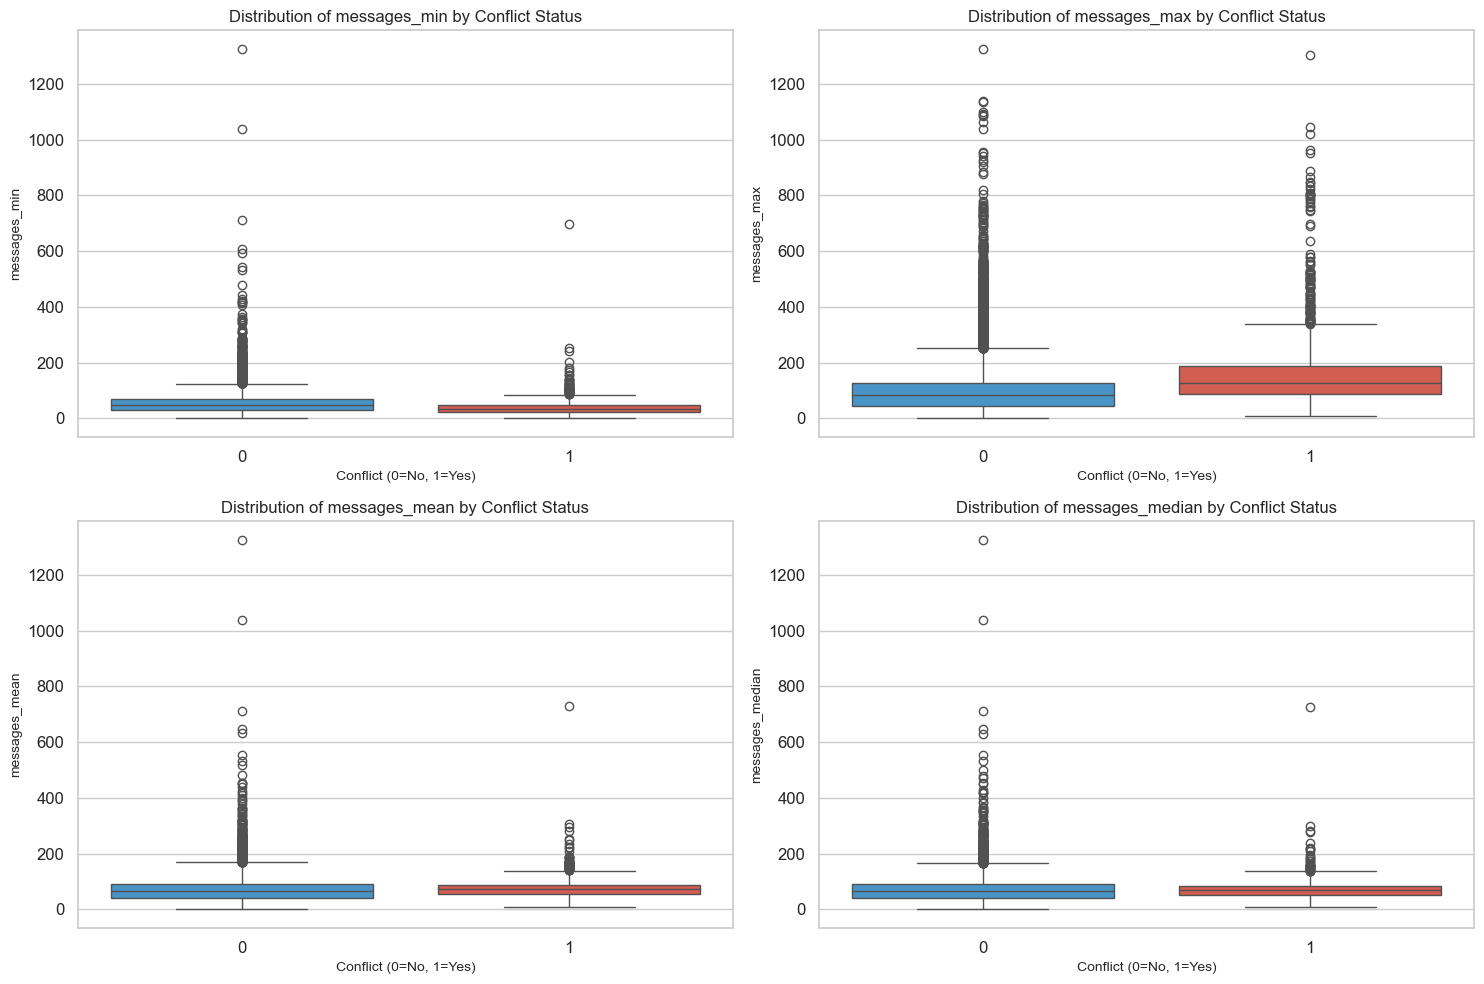

In [ ]:
# Analyze commit message features
message_features = ['fix', 'bug', 'feature', 'improve', 'document', 'refactor', 
                    'update', 'add', 'remove', 'use', 'delete', 'change',
                    'messages_min', 'messages_max', 'messages_mean', 'messages_median']

# Boxplots for commit message length features
plt.figure(figsize=(15, 10))
message_length_features = ['messages_min', 'messages_max', 'messages_mean', 'messages_median']

for i, feature in enumerate(message_length_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='conflict', y=feature, data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Conflict Status', fontsize=12)
    plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=10)
    plt.ylabel(feature, fontsize=10)
    
plt.tight_layout()
save_fig('message_length_boxplots')
plt.show()

Saving figure keyword_frequencies


<Figure size 1500x800 with 0 Axes>

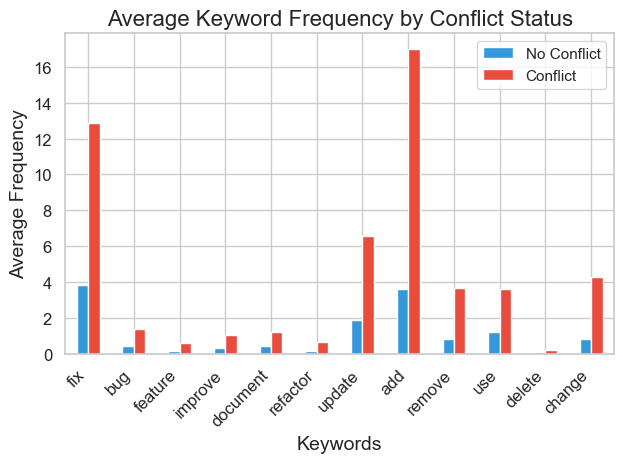

In [130]:
#  Visualize keyword frequencies
plt.figure(figsize=(15, 8))
keyword_features = ['fix', 'bug', 'feature', 'improve', 'document', 'refactor', 
                   'update', 'add', 'remove', 'use', 'delete', 'change']

keyword_means = df.groupby('conflict')[keyword_features].mean()
keyword_means.T.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Average Keyword Frequency by Conflict Status', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Average Frequency', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('keyword_frequencies')
plt.show()

Commit messages may provide insight into the nature of changes and conflict risk:
- Average message length (`messages_mean`) tends to be slightly higher in non-conflict cases
- This supports the hypothesis that better-documented commits might correlate with fewer conflicts
- Keywords like "fix", "add", and "update" appear slightly more frequently in conflict cases
- "fix" and "add" keywords show the largest differences


### Key Feature Interactions

Saving figure feature_scatter_plots


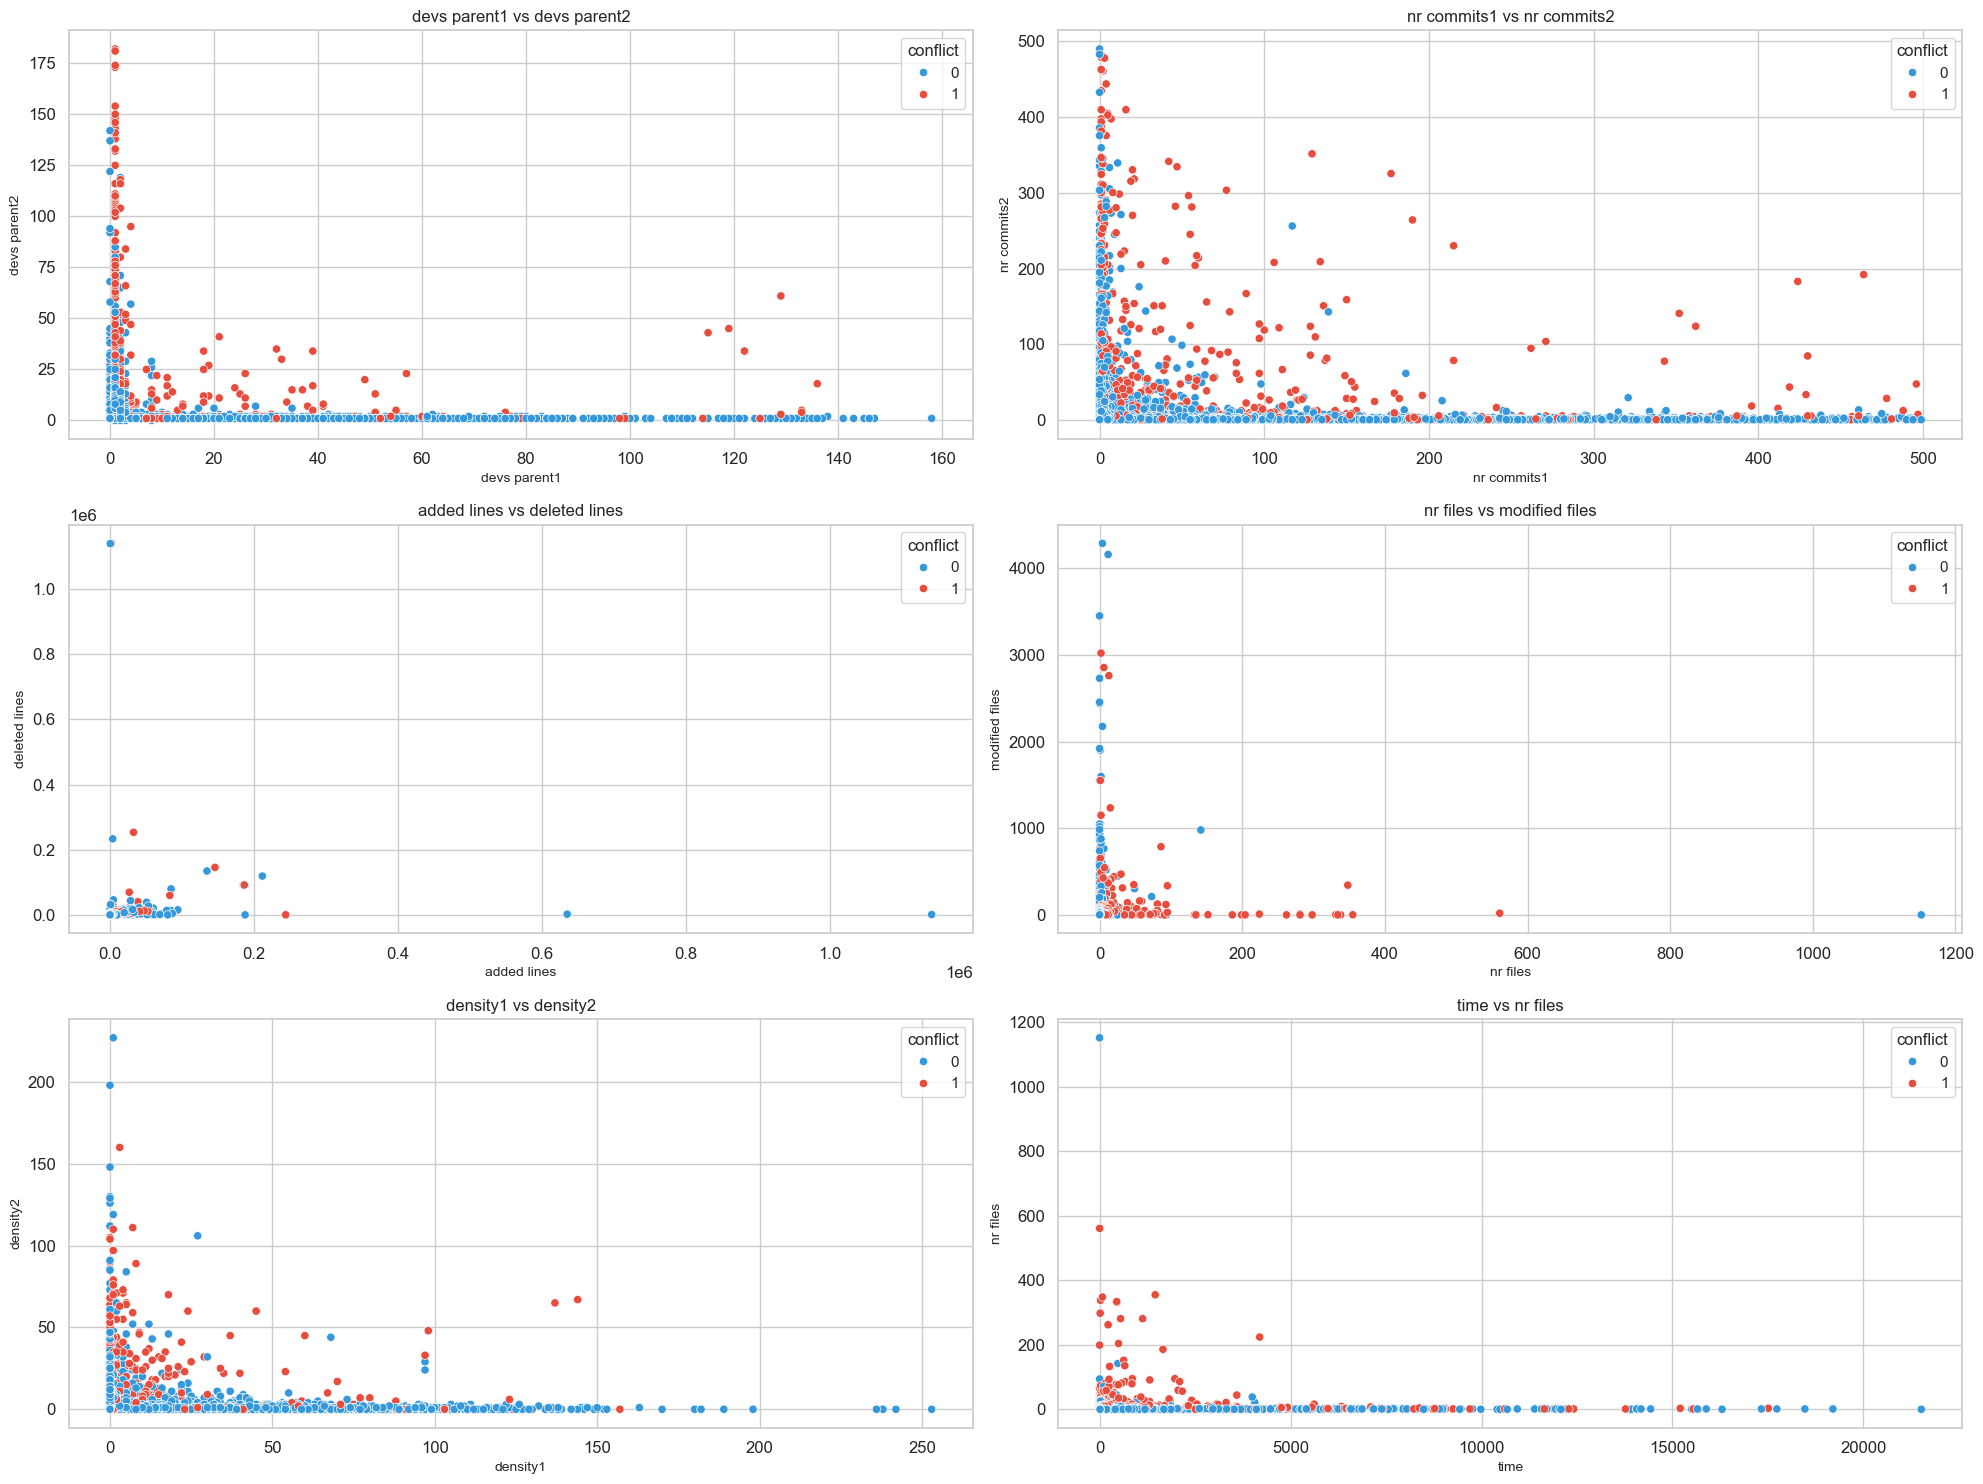

In [ ]:
# Create scatter plots for related feature pairs
plt.figure(figsize=(20, 15))
scatter_pairs = [
    ('devs parent1', 'devs parent2'),
    ('nr commits1', 'nr commits2'),
    ('added lines', 'deleted lines'),
    ('nr files', 'modified files'),
    ('density1', 'density2'),
    ('time', 'nr files')
]

for i, (x_feature, y_feature) in enumerate(scatter_pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=x_feature, y=y_feature, hue='conflict', data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'{x_feature} vs {y_feature}', fontsize=12)
    plt.xlabel(x_feature, fontsize=10)
    plt.ylabel(y_feature, fontsize=10)
    
plt.tight_layout()
save_fig('feature_scatter_plots')
plt.show()

### File-Related Features

In [ ]:
# Analyze the relationship between file metrics and conflict probability
file_features = ['nr files', 'added files', 'deleted files', 'renamed files', 'copied files', 'modified files']

# Calculate mean values by conflict status
file_metrics_by_conflict = df.groupby('conflict')[file_features].mean()
print("\nMean file metrics by conflict status:")
print(file_metrics_by_conflict)


Mean file metrics by conflict status:
          nr files  added files  deleted files  renamed files  copied files  \
conflict                                                                      
0         0.313311     2.117193       0.879671       0.480024           0.0   
1         8.374659     7.884196      10.376703       9.487057           0.0   

          modified files  
conflict                  
0               6.551108  
1              36.289510  


Saving figure file_metrics_by_conflict


<Figure size 1400x700 with 0 Axes>

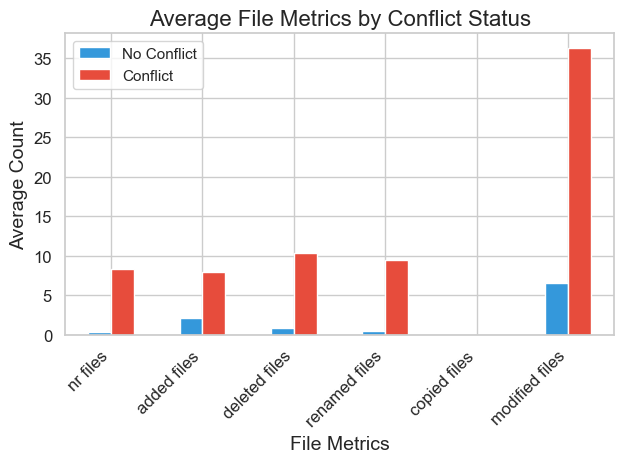

In [ ]:
# Visualize file metrics
plt.figure(figsize=(14, 7))
file_metrics_by_conflict.T.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Average File Metrics by Conflict Status', fontsize=16)
plt.xlabel('File Metrics', fontsize=14)
plt.ylabel('Average Count', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('file_metrics_by_conflict')
plt.show()

Saving figure feature_pairplot


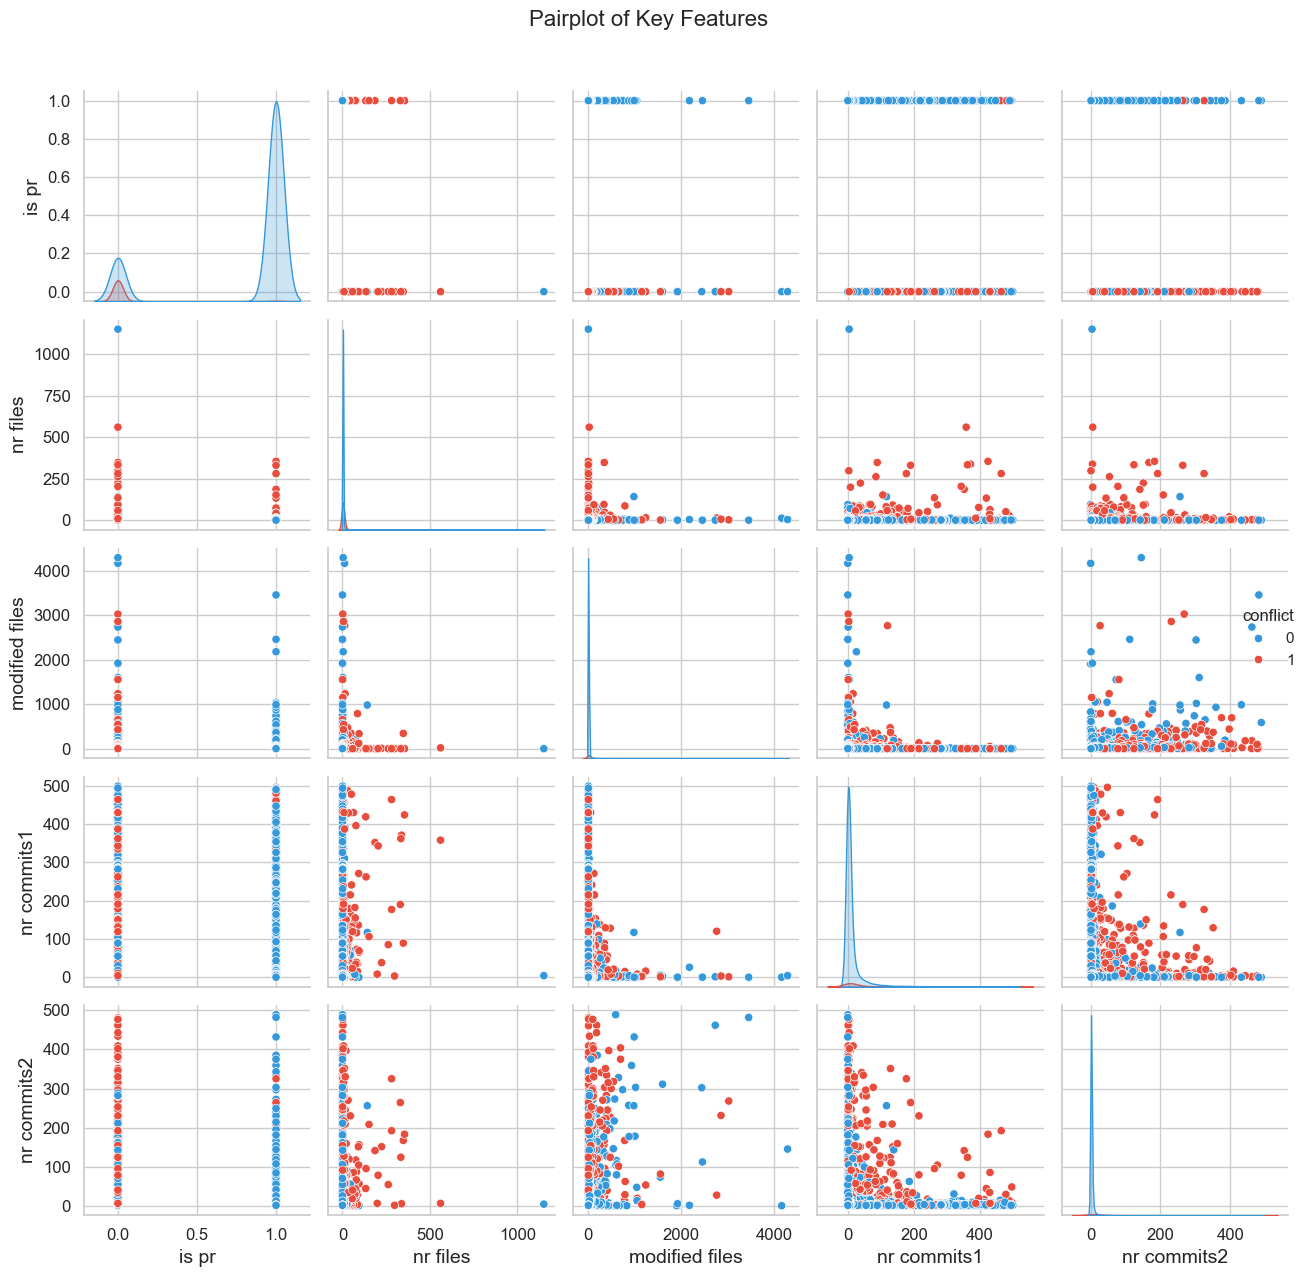

In [ ]:
# Create a pairplot for the most important features
important_features = ['is pr', 'nr files', 'modified files', 'nr commits1', 'nr commits2', 'conflict']
sns.pairplot(df[important_features], hue='conflict', palette=['#3498db', '#e74c3c'])
plt.suptitle('Pairplot of Key Features', y=1.02, fontsize=16)
save_fig('feature_pairplot')
plt.show()

# Data Preprocessing, Scaling and Encoding

## Check Feature Ranges

In [ ]:
# Print feature ranges before scaling
print("\nFeature ranges before scaling:")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X[feature].min()}, Max={X[feature].max()}, Mean={X[feature].mean():.2f}, Median={X[feature].median()}")



Feature ranges before scaling:
added lines: Min=0, Max=1140945, Mean=425.57, Median=11.0
deleted lines: Min=0, Max=1140456, Mean=250.43, Median=2.0
time: Min=0, Max=21513, Mean=240.71, Median=36.0
nr files: Min=0, Max=1152, Mean=0.75, Median=0.0
modified files: Min=0, Max=4289, Mean=8.17, Median=1.0


## Feature Scaling

Many features have widely different scales:
- `added lines` and `deleted_lines` range from 0 to over 1,140,000
- `time` ranges from 0 to over 21,000 hours
- Other features like `is pr` are binary (0 or 1)

This range disparity makes scaling necessary, especially for algorithms sensitive to feature magnitudes (like SVM). We'll use StandardScaler to normalize all features to zero mean and unit variance.

After scaling, all features have comparable magnitudes around zero with a standard deviation of 1, ensuring that no feature dominates the models due to its scale alone.

In [ ]:
# Apply StandardScaler to features
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[feature_cols] = scaler.fit_transform(X[feature_cols])

print("\nFeature ranges after scaling:")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X_scaled[feature].min():.2f}, Max={X_scaled[feature].max():.2f}, Mean={X_scaled[feature].mean():.2f}, StdDev={X_scaled[feature].std():.2f}")


Feature ranges after scaling:
added lines: Min=-0.05, Max=128.33, Mean=-0.00, StdDev=1.00
deleted lines: Min=-0.02, Max=110.93, Mean=0.00, StdDev=1.00
time: Min=-0.26, Max=23.42, Mean=0.00, StdDev=1.00
nr files: Min=-0.07, Max=108.40, Mean=0.00, StdDev=1.00
modified files: Min=-0.11, Max=57.13, Mean=-0.00, StdDev=1.00


# Train/Test Split with Stratification

Due to the significant class imbalance (5.44% conflicts), stratification is essential in our train/test split:

**Why stratification matters:**
- Without stratification, random sampling might result in too few conflict examples in the test set
- This would make evaluation unreliable and potentially misleading
- Stratification ensures both training and test sets maintain the same class distribution

We use an 80/20 train/test split with stratification on the target variable. The result confirms identical conflict ratios in both sets (5.44%), providing a solid foundation for model training and evaluation.

In [ ]:
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set conflict ratio: {100 * y_train.mean():.2f}%")
print(f"Test set conflict ratio: {100 * y_test.mean():.2f}%")


Training set shape: (21578, 32), Test set shape: (5395, 32)
Training set conflict ratio: 5.44%
Test set conflict ratio: 5.45%


Saving figure train_test_distribution


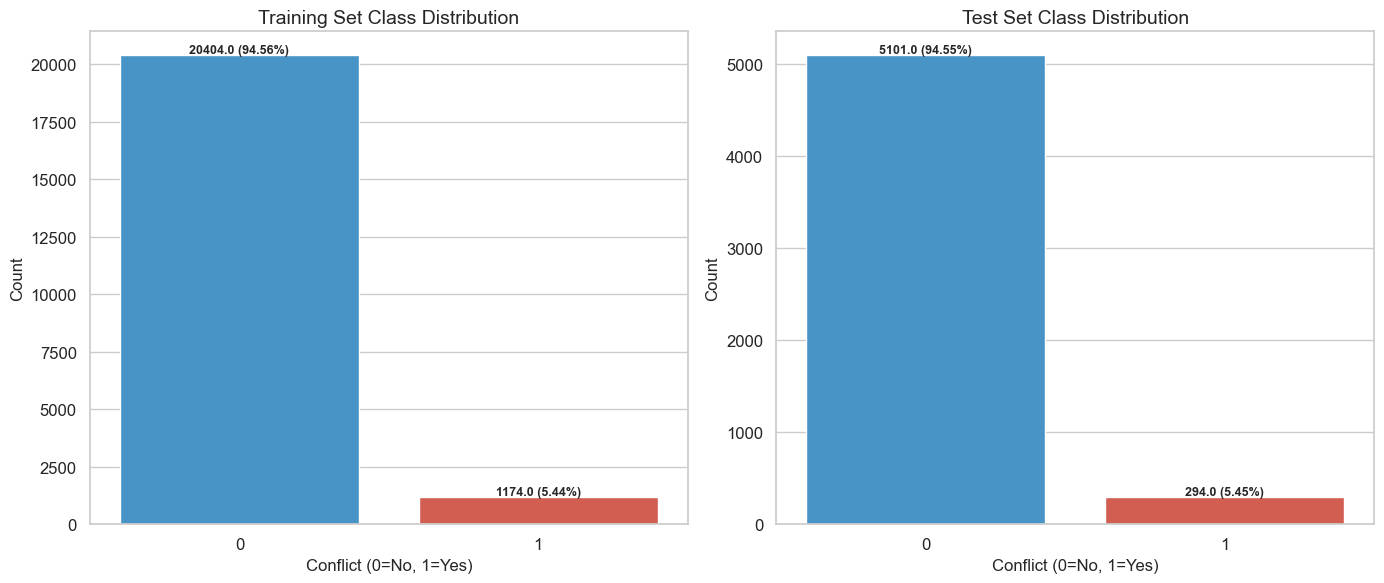

In [131]:
# Visualize class distribution in train and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
train_counts = y_train.value_counts()
ax1 = sns.countplot(x=y_train, palette=['#3498db', '#e74c3c'])
plt.title('Training Set Class Distribution', fontsize=14)
plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages on training set bars
for i, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height + 100,
            f'{height} ({height/len(y_train)*100:.2f}%)', 
            ha="center", fontsize=9, fontweight='bold')

plt.subplot(1, 2, 2)
test_counts = y_test.value_counts()
ax2 = sns.countplot(x=y_test, palette=['#3498db', '#e74c3c'])
plt.title('Test Set Class Distribution', fontsize=14)
plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages on test set bars
for i, p in enumerate(ax2.patches):
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 20,
            f'{height} ({height/len(y_test)*100:.2f}%)', 
            ha="center", fontsize=9, fontweight='bold')

plt.tight_layout()
save_fig('train_test_distribution')
plt.show()


# Performance Metric Selection

# Feature Selection